### Hugging face login

In [ ]:
from huggingface_hub import login

login()

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: fineGrained).
Your token has been saved to C:\Users\datainsight\.cache\huggingface\token
Login successful


In [2]:
import torch
import torchvision
import os
from os.path import join as j_
from PIL import Image
import pandas as pd
import numpy as np
from tqdm import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Download CRC-100K (No Norm)

You can download the CRC-100K ROI dataset at the following link: https://zenodo.org/records/1214456, which is a 9-class colorectal tissue classification task.
- Train (100K images, 11.7 GB): https://zenodo.org/records/1214456/files/NCT-CRC-HE-100K-NONORM.zip?download=1
- Test (7.180K images, 800.3 MB): https://zenodo.org/records/1214456/files/CRC-VAL-HE-7K.zip?download=1

Once you download these *.zip files, you can unzup them in your local directory (this example puts it in the `UNI/assets/data/CRC100K` relative path of the GitHub repository). The organization of these folders follows the the `torchvision.datasets.ImageFolder` structure, where the subfolders are labeled by the object class, and the images in each folder are of the same class.


In [3]:
dataroot = "D:\Aamir Gulzar\dataset\CRC100K"
assert os.path.isdir(r"D:\Aamir Gulzar\dataset\CRC100K\NCT-CRC-HE-100K-NONORM")
assert os.path.isdir(r"D:\Aamir Gulzar\dataset\CRC100K\CRC-VAL-HE-7K")

### Data Loaders

### 512x512 crc100k

In [4]:
import time
import torchvision.transforms as transforms
# get path to example data
start = time.time()
dataroot = "D:\Aamir Gulzar\dataset\CRC100K"
transform = transforms.Compose([
    transforms.Resize(512),  # Resize the image to 224x224
    transforms.ToTensor()
])


# create some image folder datasets for train/test and their data laoders
train_dataset = torchvision.datasets.ImageFolder(j_(dataroot, 'NCT-CRC-HE-100K-NONORM'), transform=transform)
test_dataset = torchvision.datasets.ImageFolder(j_(dataroot, 'CRC-VAL-HE-7K'), transform=transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=False, num_workers=1)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=1)

# create some image folder datasets for train/test and their data laoders
import torchvision
import os

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=1024, shuffle=False, num_workers=8, pin_memory=True
)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=1024, shuffle=False, num_workers=8, pin_memory=True
)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=False, num_workers=1)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=1)

In [5]:
labels_dict = train_dataset.class_to_idx
print(labels_dict)

{'ADI': 0, 'BACK': 1, 'DEB': 2, 'LYM': 3, 'MUC': 4, 'MUS': 5, 'NORM': 6, 'STR': 7, 'TUM': 8}


### Unique Class Print

In [6]:
def print_unique_class_representation(train_loader, test_loader):
    def get_unique_classes(loader):
        all_labels = []
        for _, labels in loader:
            all_labels.extend(labels.tolist())
        unique_labels, counts = torch.unique(torch.tensor(all_labels), return_counts=True)
        return unique_labels, counts

    train_unique_labels, train_counts = get_unique_classes(train_loader)
    # val_unique_labels, val_counts = get_unique_classes(val_loader)
    test_unique_labels, test_counts = get_unique_classes(test_loader)

    print("Train Loader Unique Labels and Counts:")
    print(f"Unique labels: {train_unique_labels}")
    print(f"Counts: {train_counts}")

    # print("\nValidation Loader Unique Labels and Counts:")
    # print(f"Unique labels: {val_unique_labels}")
    # print(f"Counts: {val_counts}")

    print("\nTest Loader Unique Labels and Counts:")
    print(f"Unique labels: {test_unique_labels}")
    print(f"Counts: {test_counts}")

# Example usage:
# print_unique_class_representation(train_dataloader, test_dataloader)
for batch_idx, (images, labels) in enumerate(test_dataloader):
    print(f"Batch {batch_idx}: {len(images)} images")
    print(f"Images shape: {images.shape}")
    unique_labels, counts = torch.unique(labels, return_counts=True)
    print(f"Unique labels: {unique_labels}")
    print(f"Counts: {counts}")
    if batch_idx == 2:  # Only print a few batches to check if it's working
        break

Batch 0: 256 images
Images shape: torch.Size([256, 3, 512, 512])
Unique labels: tensor([0])
Counts: tensor([256])
Batch 1: 256 images
Images shape: torch.Size([256, 3, 512, 512])
Unique labels: tensor([0])
Counts: tensor([256])
Batch 2: 256 images
Images shape: torch.Size([256, 3, 512, 512])
Unique labels: tensor([0])
Counts: tensor([256])


## Loading UNI2

## 1. CRC data Feature Extraction using UNI
1. Downloading UNI weights + Creating Model
2. The function `get_encoder` performs the commands above, downloading in the checkpoint in the `./assets/ckpts/` relative path of this GitHub repository.


In [8]:
from tqdm import tqdm
import timm

class UNI2Extractor:
    def __init__(self, device='cuda'):
        self.device = torch.device(device if torch.cuda.is_available() else 'cpu')

        timm_kwargs = {
            'img_size': 512,
            'patch_size': 16,
            'depth': 24,
            'num_heads': 24,
            'init_values': 1e-5,
            'embed_dim': 1536,
            'mlp_ratio': 2.66667 * 2,
            'num_classes': 0,
            'no_embed_class': True,
            'mlp_layer': timm.layers.SwiGLUPacked,
            'act_layer': torch.nn.SiLU,
            'reg_tokens': 8,
            'dynamic_img_size': True
        }

        self.model = timm.create_model(
            "hf-hub:MahmoodLab/UNI2-h",
            pretrained=True,
            **timm_kwargs
        ).to(self.device).half()  # Use half precision
        self.model.eval()

    def extract_features(self, dataloader):
        embeddings = []
        labels = []
        with torch.no_grad():
            for imgs, lbls in tqdm(dataloader, desc="Extracting Features"):
                imgs = imgs.half().to(self.device, non_blocking=True)  # send to GPU in half precision
                feats = self.model(imgs)
                embeddings.append(feats.cpu())
                labels.append(lbls)

        return {
            "embeddings": torch.cat(embeddings).numpy(),
            "labels": torch.cat(labels).numpy()
        }

In [9]:
extractor = UNI2Extractor()
train_features_uni2 = extractor.extract_features(train_dataloader)
test_features_uni2 = extractor.extract_features(test_dataloader)

train_feats_uni2 = torch.Tensor(train_features_uni2['embeddings'])
train_labels_uni2 = torch.Tensor(train_features_uni2['labels']).type(torch.long)
test_feats_uni2 = torch.Tensor(test_features_uni2['embeddings'])
test_labels_uni2 = torch.Tensor(test_features_uni2['labels']).type(torch.long)

Extracting Features:   0%|                                                                     | 0/391 [00:00<?, ?it/s]C:\Users\datainsight\anaconda3\envs\exaonepath\lib\site-packages\timm\layers\attention.py:80: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  x = F.scaled_dot_product_attention(
Extracting Features: 100%|█████████████████████████████████████████████████████████████| 29/29 [01:53<00:00,  3.92s/it]


In [10]:
import os
import torch

# Create folder if it doesn't exist
output_dir = 'UNI2_upscaled_feature'
os.makedirs(output_dir, exist_ok=True)

# Save tensors
torch.save(train_feats_uni2, os.path.join(output_dir, 'train_feats.pt'))
torch.save(train_labels_uni2, os.path.join(output_dir, 'train_labels.pt'))
torch.save(test_feats_uni2, os.path.join(output_dir, 'test_feats.pt'))
torch.save(test_labels_uni2, os.path.join(output_dir, 'test_labels.pt'))

print("✅ Features and labels saved to 'UNI2_feature/' folder.")

✅ Features and labels saved to 'UNI2_feature/' folder.


## UNI2 features

In [11]:
import torch

# Folder path
input_dir = 'UNI2_upscaled_feature'

# Load tensors
train_feats_uni2 = torch.load(f'{input_dir}/train_feats.pt')
train_labels_uni2 = torch.load(f'{input_dir}/train_labels.pt')
test_feats_uni2 = torch.load(f'{input_dir}/test_feats.pt')
test_labels_uni2 = torch.load(f'{input_dir}/test_labels.pt')

## 2. Feature Identification Using CONCH

In [12]:
# Test if conch_v1_5 working
from transformers import AutoModel
titan = AutoModel.from_pretrained("MahmoodLab/TITAN", trust_remote_code=True)
model, preprocess = titan.return_conch()

print(type(model))

<class 'transformers_modules.MahmoodLab.TITAN.b2fb4f475256eb67c6e9ccbf2d6c9c3f25f20791.conch_v1_5.EncoderWithAttentionalPooler'>


In [ ]:
from transformers import AutoModel
from huggingface_hub import login
from PIL import Image
import torch, os
import numpy as np
from typing import List, Union

class ConchFeatureExtractor:
    def __init__(self, token=""):
        login(token=token)
        self.model = AutoModel.from_pretrained("MahmoodLab/TITAN", trust_remote_code=True)
        self.conch, self.eval_transform = self.model.return_conch()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.conch = self.conch.to(self.device).eval()

    def extract_features(self, paths: List[str], batch_size: int = 256):
        all_feats = []

        with torch.inference_mode(), torch.autocast("cuda"):  # Enable FP16
            for i in range(0, len(paths), batch_size):
                batch_paths = paths[i:i+batch_size]
                imgs = []
                for p in batch_paths:
                    img = Image.open(p).convert("RGB")
                    imgs.append(self.eval_transform(img))
                batch_tensor = torch.stack(imgs).to(self.device, non_blocking=True)
                feats = self.conch(batch_tensor).cpu()
                all_feats.append(feats)

        return torch.cat(all_feats, dim=0).numpy()


In [14]:
from tqdm import tqdm

def extract_patch_features_conch15(extractor, dataloader):
    all_embeddings, all_labels = [], []

    all_paths = [path for path, _ in dataloader.dataset.samples]
    all_targets = [label for _, label in dataloader.dataset.samples]

    features = extractor.extract_features(all_paths, batch_size=dataloader.batch_size)
    all_embeddings = features
    all_labels = np.array(all_targets)

    return {
        "embeddings": all_embeddings.astype(np.float32),
        "labels": all_labels
    }

## Feature extraction with conch

In [ ]:
start = time.time()
extractor = ConchFeatureExtractor(token="")

train_features_conch = extract_patch_features_conch15(extractor, train_dataloader)
test_features_conch = extract_patch_features_conch15(extractor, test_dataloader)

train_feats_conch = torch.tensor(train_features_conch['embeddings'])
train_labels_conch = torch.tensor(train_features_conch['labels']).long()
test_feats_conch = torch.tensor(test_features_conch['embeddings'])
test_labels_conch = torch.tensor(test_features_conch['labels']).long()

elapsed = time.time() - start
print(f"Took {elapsed:.03f} seconds")
print(f"Train features shape {train_feats_conch.shape}, Labels shape: {train_labels_conch.shape}")
print(f"Test features shape {test_feats_conch.shape}, Labels shape: {test_labels_conch.shape}")


The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: fineGrained).
Your token has been saved to C:\Users\datainsight\.cache\huggingface\token
Login successful
Took 1144.215 seconds
Train features shape torch.Size([100000, 768]), Labels shape: torch.Size([100000])
Test features shape torch.Size([7180, 768]), Labels shape: torch.Size([7180])


In [16]:
import os
import torch

# Create folder if it doesn't exist
conch_dir = 'Conch_upscaled_features'
os.makedirs(conch_dir, exist_ok=True)

# Save tensors
torch.save(train_feats_conch, os.path.join(conch_dir, 'train_feats.pt'))
torch.save(train_labels_conch, os.path.join(conch_dir, 'train_labels.pt'))
torch.save(test_feats_conch, os.path.join(conch_dir, 'test_feats.pt'))
torch.save(test_labels_conch, os.path.join(conch_dir, 'test_labels.pt'))

print("✅ Conch features and labels saved to 'Conch_features/' folder.")

✅ Conch features and labels saved to 'Conch_features/' folder.


## Conch features 

In [17]:
import torch

# Folder path
conch_dir = 'Conch_upscaled_features'

# Load tensors
train_feats_conch = torch.load(f'{conch_dir}/train_feats.pt')
train_labels_conch = torch.load(f'{conch_dir}/train_labels.pt')
test_feats_conch = torch.load(f'{conch_dir}/test_feats.pt')
test_labels_conch = torch.load(f'{conch_dir}/test_labels.pt')

In [18]:
train_feats_conch[0].size()

torch.Size([768])

### ANN Model

In [19]:
from sklearn.metrics import classification_report
import pandas as pd

def plot_classification_report(y_true, y_pred, target_names=None):
    report_dict = classification_report(y_true, y_pred, target_names=target_names, output_dict=True)
    df = pd.DataFrame(report_dict).transpose()
    
    plt.figure(figsize=(10, 6))
    sns.heatmap(df.iloc[:-1, :-1], annot=True, cmap="YlGnBu", fmt=".2f")
    plt.title("Classification Report")
    plt.show()
    
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

def plot_roc_multiclass(y_true, y_score, n_classes):
    y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    colors = cycle(sns.color_palette("husl", n_classes))
    plt.figure(figsize=(10, 8))
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='Class {0} (AUC = {1:0.2f})'.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-class ROC Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

def plot_prediction_confidence(probs, preds, targets):
    confidences = probs[np.arange(len(preds)), preds]
    correct = preds == targets

    plt.figure(figsize=(10, 6))
    sns.histplot(confidences[correct], color='green', label='Correct', kde=True, stat='density')
    sns.histplot(confidences[~correct], color='red', label='Incorrect', kde=True, stat='density')
    plt.xlabel("Prediction Confidence")
    plt.ylabel("Density")
    plt.title("Prediction Confidence Distribution")
    plt.legend()
    plt.grid(True)
    plt.show()


In [20]:
import torch
from typing import Tuple, Dict, Any, List
import torch.nn.functional as F
import numpy as np
import time
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from UNI_main.metrics import get_eval_metrics
import matplotlib.pyplot as plt


class ANNClassifier:
    def __init__(self, input_dim=None, hidden_dim1=224, hidden_dim2=128, C=1.0, max_iter=100, verbose=True, random_state=42):
        self.C = C
        self.loss_func = torch.nn.CrossEntropyLoss()
        self.max_iter = max_iter
        self.random_state = random_state
        self.verbose = verbose
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.input_dim = input_dim  # Will be set during fit() if None
        self.hidden_dim1 = hidden_dim1
        self.hidden_dim2 = hidden_dim2
        self.model = None

    def compute_loss(self, preds, labels):
        loss = self.loss_func(preds, labels)
        wreg = 0.5 * sum((param.norm(p=2) for param in self.model.parameters()))  # L2 regularization
        return loss.mean() + (1.0 / self.C) * wreg

    def predict_proba(self, feats):
        feats = feats.to(self.device)
        with torch.no_grad():
            return torch.softmax(self.model(feats), dim=1)


    def fit(self, feats, labels):
        torch.manual_seed(self.random_state)
        np.random.seed(self.random_state)
    
        # Set input_dim if not set
        if self.input_dim is None:
            self.input_dim = feats.shape[1]
    
        self.model = torch.nn.Sequential(
            torch.nn.Linear(self.input_dim, self.hidden_dim1),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.3),
            torch.nn.Linear(self.hidden_dim1, self.hidden_dim2),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.3),
            torch.nn.Linear(self.hidden_dim2, 9)  # Assuming 9 classes
        ).to(self.device)
    
        for layer in self.model:
            if isinstance(layer, torch.nn.Linear):
                torch.nn.init.xavier_uniform_(layer.weight)
    
        feats = feats.to(self.device)
        labels = labels.long().to(self.device)
    
        opt = torch.optim.Adam(self.model.parameters(), lr=1e-3, weight_decay=1e-5)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=5)
    
        min_loss = np.inf
        patience = 10
        patience_counter = 0
    
        # For plotting
        self.train_losses = []
        self.lr_schedule = []
        self.grad_norms = []
    
        for epoch in range(self.max_iter):
            opt.zero_grad()
            preds = self.model(feats)
            loss = self.compute_loss(preds, labels)
            loss.backward()
    
            # Save gradient norm
            total_norm = 0.0
            for p in self.model.parameters():
                if p.grad is not None:
                    param_norm = p.grad.data.norm(2)
                    total_norm += param_norm.item() ** 2
            self.grad_norms.append(total_norm ** 0.5)
    
            opt.step()
            scheduler.step(loss)
    
            # Save loss and learning rate
            self.train_losses.append(loss.item())
            self.lr_schedule.append(opt.param_groups[0]['lr'])
    
            if self.verbose and epoch % 10 == 0:
                print(f"Epoch {epoch}: Loss: {loss:.4f}")
    
            if loss < min_loss:
                min_loss = loss
                patience_counter = 0
                best_model = self.model.state_dict()
            else:
                patience_counter += 1
    
            # Uncomment for early stopping
            # if patience_counter >= patience:
            #     print(f"Early stopping at epoch {epoch}")
            #     break
    
        self.model.load_state_dict(best_model)
    
        if self.verbose:
            print(f"Final Loss: {min_loss:.4f}")
            self._plot_training_curves()
    
    def _plot_training_curves(self):
        plt.figure(figsize=(16, 4))
    
        # Plot 1: Training Loss
        plt.subplot(1, 3, 1)
        plt.plot(self.train_losses, label='Training Loss', color='blue')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training Loss Over Epochs')
        plt.grid(True)
        plt.legend()
    
        # Plot 2: Learning Rate
        plt.subplot(1, 3, 2)
        plt.plot(self.lr_schedule, label='Learning Rate', color='green')
        plt.xlabel('Epoch')
        plt.ylabel('LR')
        plt.title('Learning Rate Schedule')
        plt.grid(True)
        plt.legend()
    
        # Plot 3: Gradient Norms
        plt.subplot(1, 3, 3)
        plt.plot(self.grad_norms, label='Gradient Norm', color='red')
        plt.xlabel('Epoch')
        plt.ylabel('L2 Norm')
        plt.title('Gradient Norm Over Epochs')
        plt.grid(True)
        plt.legend()
    
        plt.tight_layout()
        plt.show()


def eval_ANN_probe(
    train_feats: torch.Tensor,
    train_labels: torch.Tensor,
    valid_feats: torch.Tensor,
    valid_labels: torch.Tensor,
    test_feats: torch.Tensor,
    test_labels: torch.Tensor,
    max_iter: int = 1000,
    combine_trainval: bool = True,
    verbose: bool = True,
    save_path: str = None,
    hidden_dim1=224,
    hidden_dim2=128,
    C=1.0
) -> Tuple[Dict[str, Any], Dict[str, Any]]:

    start = time.time()
    classifier = train_ANN_probe(
        train_feats, train_labels,
        valid_feats, valid_labels,
        max_iter=max_iter,
        combine_trainval=combine_trainval,
        verbose=verbose,
        hidden_dim1=hidden_dim1,
        hidden_dim2=hidden_dim2,
        C=C
    )

    results, dump = test_ANN_probe(classifier, test_feats, test_labels, prefix="ann_", verbose=verbose)
    classifier.model = classifier.model.to(torch.device("cpu"))
    dump["model"] = classifier.model.state_dict()

    if save_path is not None:
        torch.save(classifier.model, save_path)
        if verbose:
            print(f"Model saved at: {save_path}")
    del classifier
    torch.cuda.empty_cache()
    if verbose:
        print(f"ANN Probe Evaluation: Time taken {time.time() - start:.2f} and model saved : {save_path}")

    return results, dump

def train_ANN_probe(
    train_feats,
    train_labels,
    valid_feats,
    valid_labels,
    max_iter=1000,
    combine_trainval=True,
    verbose=True,
    hidden_dim1=224,
    hidden_dim2=128,
    C=1.0,
):
    if combine_trainval and valid_feats is not None:
        trainval_feats = torch.cat([train_feats, valid_feats], dim=0)
        trainval_labels = torch.cat([train_labels, valid_labels], dim=0)
        if verbose:
            print("Combining train and validation sets. Trainval shape: ", trainval_feats.shape)
        classifier = ANNClassifier(hidden_dim1=hidden_dim1, hidden_dim2=hidden_dim2, C=C, max_iter=max_iter, verbose=verbose)
        classifier.fit(trainval_feats, trainval_labels)
    else:
        classifier = ANNClassifier(hidden_dim1=hidden_dim1, hidden_dim2=hidden_dim2, C=C, max_iter=max_iter, verbose=verbose)
        classifier.fit(train_feats, train_labels)
    return classifier

def test_ANN_probe(
    classifier: ANNClassifier,
    test_feats: torch.Tensor,
    test_labels: torch.Tensor,
    prefix: str = "ann_",
    verbose: bool = True,
) -> Tuple[Dict[str, Any], Dict[str, Any]]:
    if verbose:
        print(f"ANN Probe Evaluation: Test shape {test_feats.shape}")

    probs_all = classifier.predict_proba(test_feats).cpu().numpy()
    preds_all = np.argmax(probs_all, axis=1)
    targets_all = test_labels.cpu().numpy()
    roc_kwargs = {"multi_class": "ovo", "average": "macro"}

    # ⬇️ Calculate accuracy
    accuracy = np.mean(preds_all == targets_all)
    print(f"✅ Test Accuracy: {accuracy * 100:.2f}%")

    # ⬇️ Eval metrics
    eval_metrics = get_eval_metrics(targets_all, preds_all, probs_all, True, prefix, roc_kwargs)
    dump = {"preds_all": preds_all, "probs_all": probs_all, "targets_all": targets_all}

    # ⬇️ Confusion matrix
    conf_matrix = confusion_matrix(targets_all, preds_all)
    print("Confusion Matrix:")
    plot_confusion_matrix(conf_matrix)
    
    # ⬇️ New plots for deeper insight
    plot_classification_report(targets_all, preds_all)
    plot_roc_multiclass(targets_all, probs_all, n_classes=9)
    plot_prediction_confidence(probs_all, preds_all, targets_all)


    return eval_metrics, dump

    
def plot_confusion_matrix(cm):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True,fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

In [21]:
from sklearn.model_selection import train_test_split
from itertools import product

def ann_grid_search(
    train_feats, train_labels,
    test_feats, test_labels,
    validation_split=0.2,
    seed=42
):
    # Split train_feats into training and validation parts
    train_idx, val_idx = train_test_split(
        np.arange(train_feats.shape[0]),
        test_size=validation_split,
        random_state=seed,
        stratify=train_labels.cpu().numpy()  # Preserves class distribution
    )
    train_feats_split = train_feats[train_idx]
    train_labels_split = train_labels[train_idx]
    val_feats_split = train_feats[val_idx]
    val_labels_split = train_labels[val_idx]

    # Grid parameters
    hidden_dim1_vals = [128, 224, 256]
    hidden_dim2_vals = [64, 128]
    C_vals = [0.1, 1.0, 10.0]
    max_iter_vals = [500]

    best_score = -np.inf
    best_params = None
    best_classifier = None

    for h1, h2, c, m in product(hidden_dim1_vals, hidden_dim2_vals, C_vals, max_iter_vals):
        print(f"Trying: hidden_dim1={h1}, hidden_dim2={h2}, C={c}, max_iter={m}")
        classifier = ANNClassifier(
            hidden_dim1=h1,
            hidden_dim2=h2,
            C=c,
            max_iter=m,
            verbose=False
        )
        classifier.fit(train_feats_split, train_labels_split)

        # Evaluate on validation set
        probs = classifier.predict_proba(val_feats_split).cpu().numpy()
        preds = np.argmax(probs, axis=1)
        targets = val_labels_split.cpu().numpy()
        acc = np.mean(preds == targets)

        print(f"Validation Accuracy: {acc:.4f}")

        if acc > best_score:
            best_score = acc
            best_params = {'hidden_dim1': h1, 'hidden_dim2': h2, 'C': c, 'max_iter': m}
            best_classifier = classifier

    print("\n✅ Best Parameters:", best_params)
    print("📈 Best Validation Accuracy:", best_score)
    return best_params, best_classifier

## UNI2 model

Trying: hidden_dim1=128, hidden_dim2=64, C=0.1, max_iter=500
Validation Accuracy: 0.1041
Trying: hidden_dim1=128, hidden_dim2=64, C=1.0, max_iter=500
Validation Accuracy: 0.1041
Trying: hidden_dim1=128, hidden_dim2=64, C=10.0, max_iter=500
Validation Accuracy: 0.9860
Trying: hidden_dim1=128, hidden_dim2=128, C=0.1, max_iter=500
Validation Accuracy: 0.1041
Trying: hidden_dim1=128, hidden_dim2=128, C=1.0, max_iter=500
Validation Accuracy: 0.1041
Trying: hidden_dim1=128, hidden_dim2=128, C=10.0, max_iter=500
Validation Accuracy: 0.9868
Trying: hidden_dim1=224, hidden_dim2=64, C=0.1, max_iter=500
Validation Accuracy: 0.1041
Trying: hidden_dim1=224, hidden_dim2=64, C=1.0, max_iter=500
Validation Accuracy: 0.1041
Trying: hidden_dim1=224, hidden_dim2=64, C=10.0, max_iter=500
Validation Accuracy: 0.9861
Trying: hidden_dim1=224, hidden_dim2=128, C=0.1, max_iter=500
Validation Accuracy: 0.1041
Trying: hidden_dim1=224, hidden_dim2=128, C=1.0, max_iter=500
Validation Accuracy: 0.1041
Trying: hidde

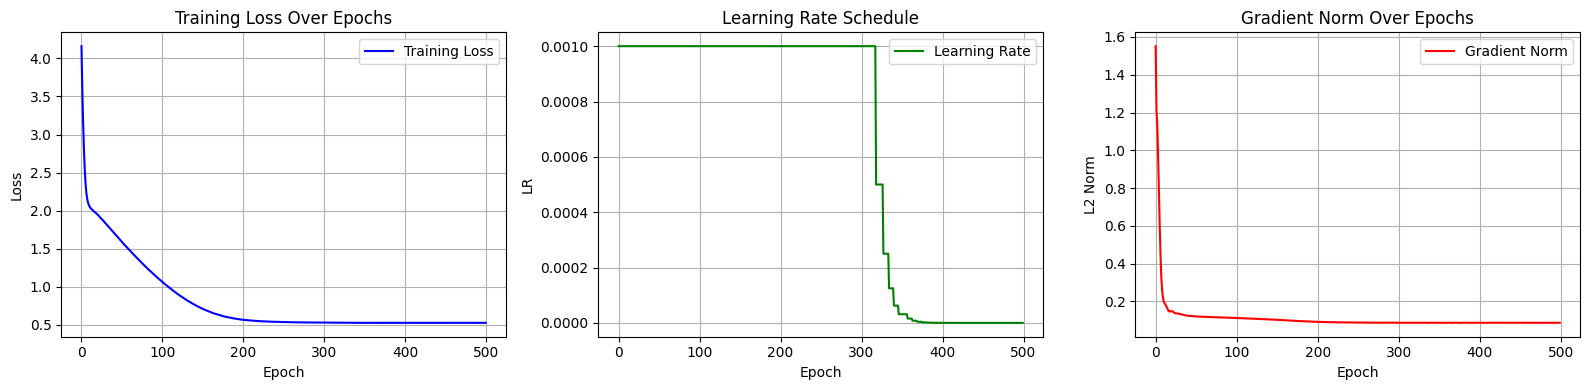

ANN Probe Evaluation: Test shape torch.Size([7180, 1536])
✅ Test Accuracy: 96.64%
Confusion Matrix:


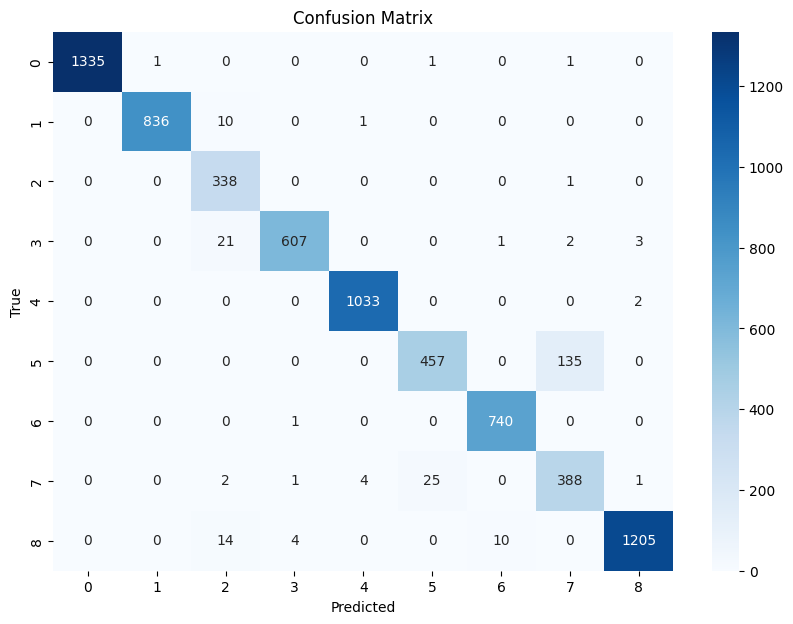

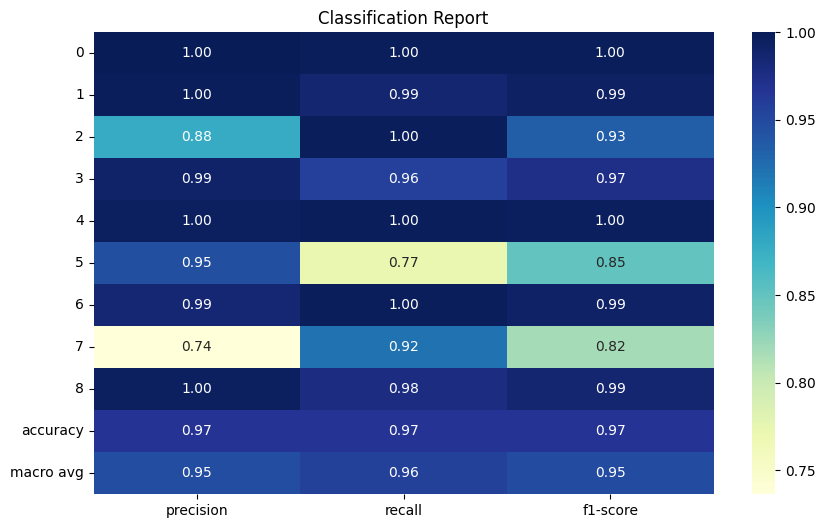

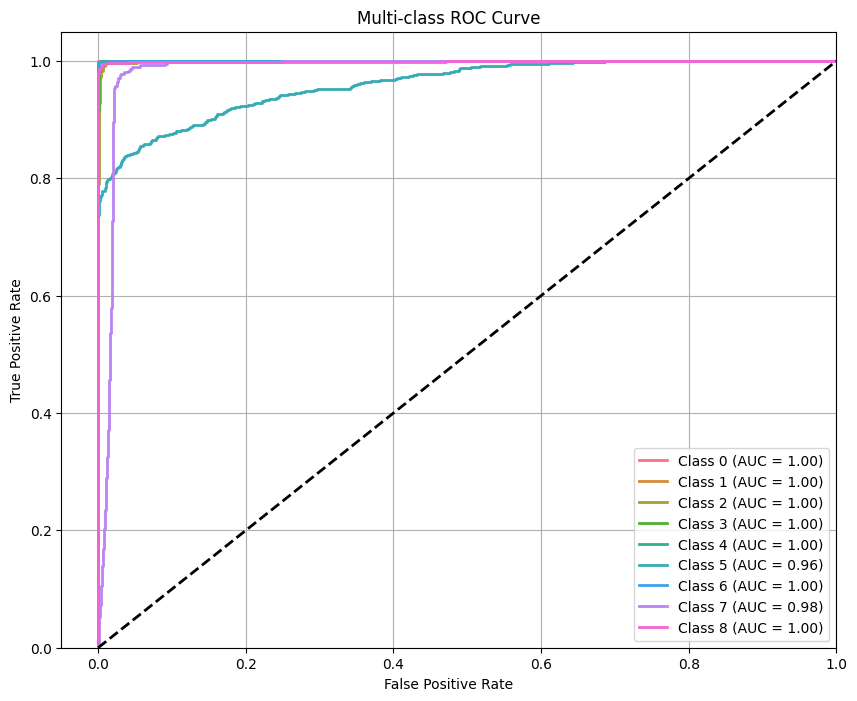

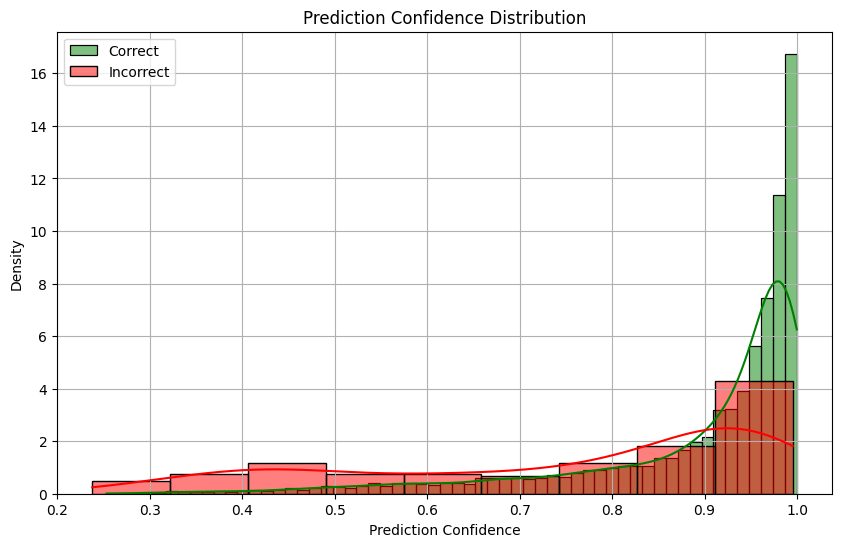

Model saved at: ./models/ann_crc100k_upscaled_uni2.pth
ANN Probe Evaluation: Time taken 7.39 and model saved : ./models/ann_crc100k_upscaled_uni2.pth


In [22]:
best_params, _ = ann_grid_search(
    train_feats=train_feats_uni2,
    train_labels=train_labels_uni2,
    test_feats=test_feats_uni2,
    test_labels=test_labels_uni2
)

import torch

# Train final model on full training set with best parameters
linprobe_eval_metrics, linprobe_dump = eval_ANN_probe(
    train_feats=train_feats_uni2,
    train_labels=train_labels_uni2,
    valid_feats=None,
    valid_labels=None,
    test_feats=test_feats_uni2,
    test_labels=test_labels_uni2,
    max_iter=best_params['max_iter'],
    hidden_dim1=best_params['hidden_dim1'],
    hidden_dim2=best_params['hidden_dim2'],
    C=best_params['C'],
    verbose=True,
    save_path='./models/ann_crc100k_upscaled_uni2.pth'
)

In [23]:
best_params

{'hidden_dim1': 256, 'hidden_dim2': 128, 'C': 10.0, 'max_iter': 500}

In [24]:
import json

with open('best_parameters/best_params_upscale_uni2.json', 'w') as f:
    json.dump(best_params, f, indent=4)

print("✅ Saved best_params to best_params.json")

✅ Saved best_params to best_params.json


## Conch 1.5 model

Trying: hidden_dim1=128, hidden_dim2=64, C=0.1, max_iter=500
Validation Accuracy: 0.1041
Trying: hidden_dim1=128, hidden_dim2=64, C=1.0, max_iter=500
Validation Accuracy: 0.7996
Trying: hidden_dim1=128, hidden_dim2=64, C=10.0, max_iter=500
Validation Accuracy: 0.9690
Trying: hidden_dim1=128, hidden_dim2=128, C=0.1, max_iter=500
Validation Accuracy: 0.1041
Trying: hidden_dim1=128, hidden_dim2=128, C=1.0, max_iter=500
Validation Accuracy: 0.8270
Trying: hidden_dim1=128, hidden_dim2=128, C=10.0, max_iter=500
Validation Accuracy: 0.9688
Trying: hidden_dim1=224, hidden_dim2=64, C=0.1, max_iter=500
Validation Accuracy: 0.1041
Trying: hidden_dim1=224, hidden_dim2=64, C=1.0, max_iter=500
Validation Accuracy: 0.8230
Trying: hidden_dim1=224, hidden_dim2=64, C=10.0, max_iter=500
Validation Accuracy: 0.9696
Trying: hidden_dim1=224, hidden_dim2=128, C=0.1, max_iter=500
Validation Accuracy: 0.1041
Trying: hidden_dim1=224, hidden_dim2=128, C=1.0, max_iter=500
Validation Accuracy: 0.8445
Trying: hidde

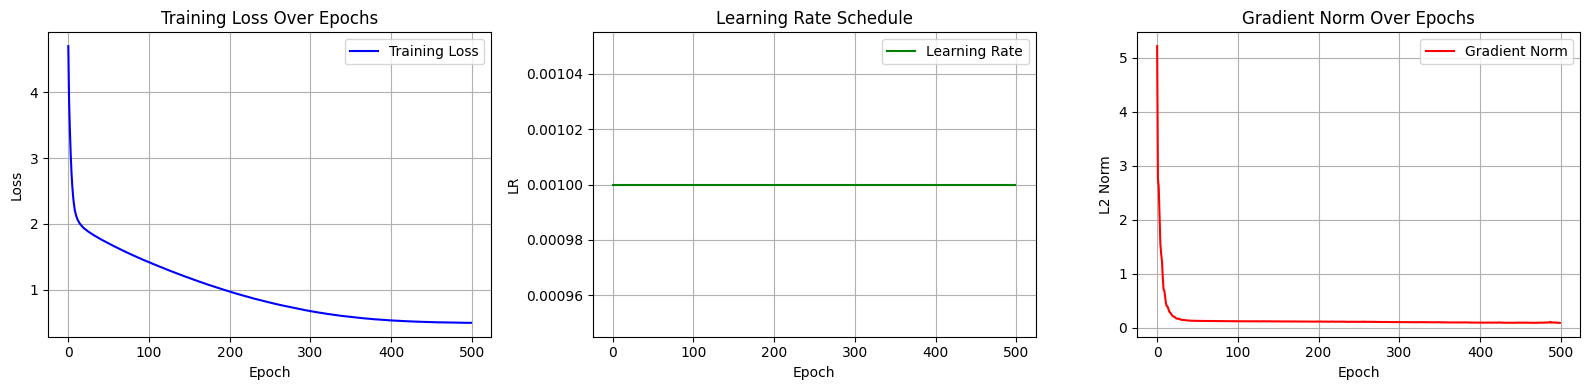

ANN Probe Evaluation: Test shape torch.Size([7180, 768])
✅ Test Accuracy: 89.50%
Confusion Matrix:


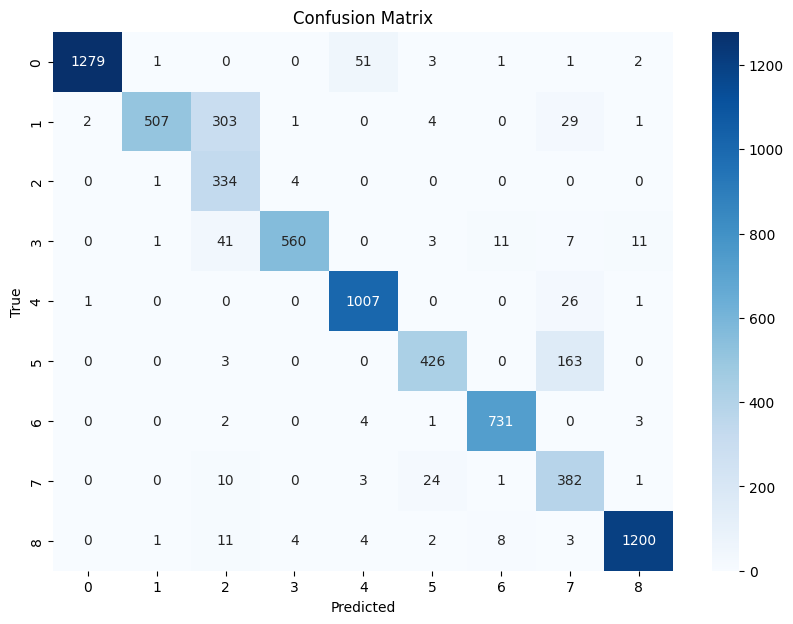

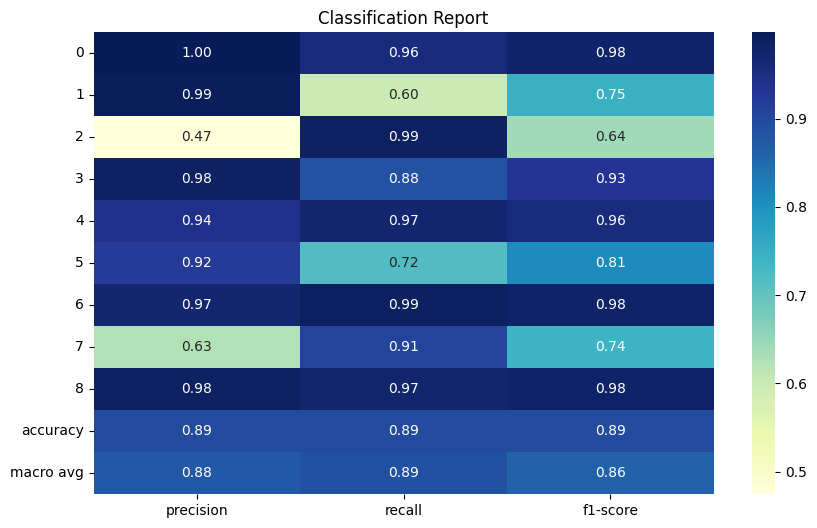

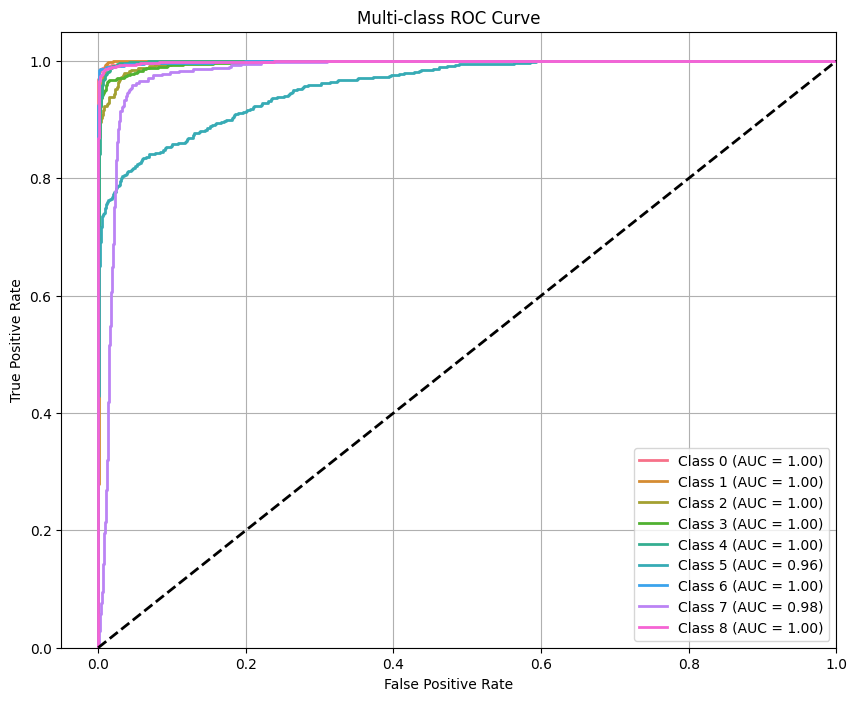

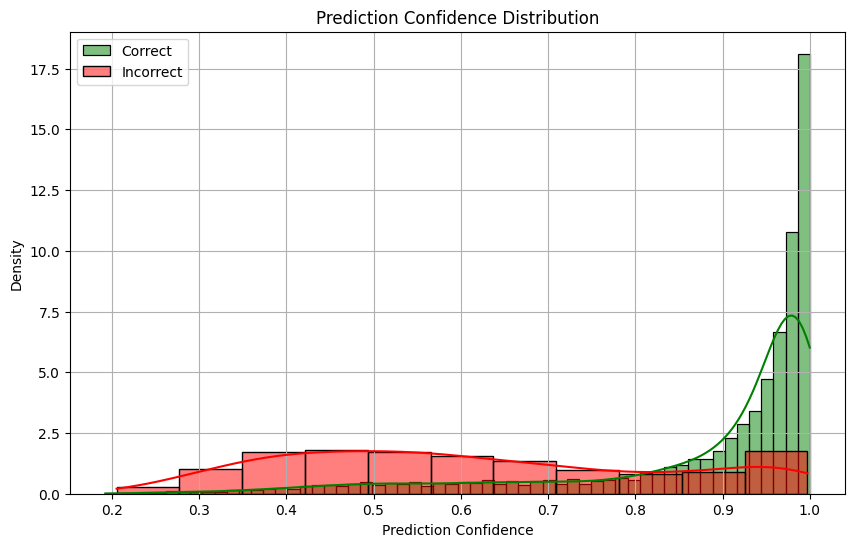

Model saved at: ./models/ann_crc100k_upscale_conch15.pth
ANN Probe Evaluation: Time taken 5.66 and model saved : ./models/ann_crc100k_upscale_conch15.pth


In [25]:
best_params, _ = ann_grid_search(
    train_feats=train_feats_conch,
    train_labels=train_labels_conch,
    test_feats=test_feats_conch,
    test_labels=test_labels_conch
)
import torch

# Train final model on full training set with best parameters
linprobe_eval_metrics, linprobe_dump = eval_ANN_probe(
    train_feats=train_feats_conch,
    train_labels=train_labels_conch,
    valid_feats=None,
    valid_labels=None,
    test_feats=test_feats_conch,
    test_labels=test_labels_conch,
    max_iter=best_params['max_iter'],
    hidden_dim1=best_params['hidden_dim1'],
    hidden_dim2=best_params['hidden_dim2'],
    C=best_params['C'],
    verbose=True,
    save_path='./models/ann_crc100k_upscale_conch15.pth'
)

In [26]:
best_params

{'hidden_dim1': 224, 'hidden_dim2': 128, 'C': 10.0, 'max_iter': 500}

In [27]:
import json

with open('best_parameters/best_params_upscale_conch.json', 'w') as f:
    json.dump(best_params, f, indent=4)

print("✅ Saved best_params to best_params.json")

✅ Saved best_params to best_params.json
